In [2]:
import numpy as np
# import h5py
from scipy.stats import gaussian_kde
from loadmodules import *
import sys
sys.path.append('./gizmo_test/gizmo-public/scripts/')
import load_from_snapshot

datadir = './runtest/'
plummer_1 = 'plummer_arepo/'
plummer_2 = 'plummer_gizmo/'

In [3]:
%matplotlib inline

In [4]:
s = gadget_readsnap(2, snappath=datadir+plummer_1, applytransformationfacs=True, snapbase='snapshot_')
s.data['r'] = np.sqrt(s.data['pos'][:,0]**2 + s.data['pos'][:,1]**2 + s.data['pos'][:,2]**2)

/home/pdcg/pylib/gadget_snap.py:730: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


In [5]:
solar_mass_g = 1.99e33 # g
s.data['mass'] *= s.UnitMass_in_g / solar_mass_g
gyr = 3.16e16 # in s
kpc = 3.09e21 # cm
G = 6.67e-8 # cm3 g-1 s-2
Mplummer = (s.data['mass']).sum()

In [6]:
m_g = load_from_snapshot.load_from_snapshot('Masses', 4, datadir+plummer_2, 2) * s.UnitMass_in_g / solar_mass_g
pos_g = load_from_snapshot.load_from_snapshot('Coordinates', 4, datadir+plummer_2, 2)
TT_g = load_from_snapshot.load_from_snapshot('TidalTensor', 4, datadir+plummer_2, 2)

r_g = np.sqrt(pos_g[:,0]**2 + pos_g[:,1]**2 + pos_g[:,2]**2)

[(-5.0, 5.0), (-5.0, 5.0)]

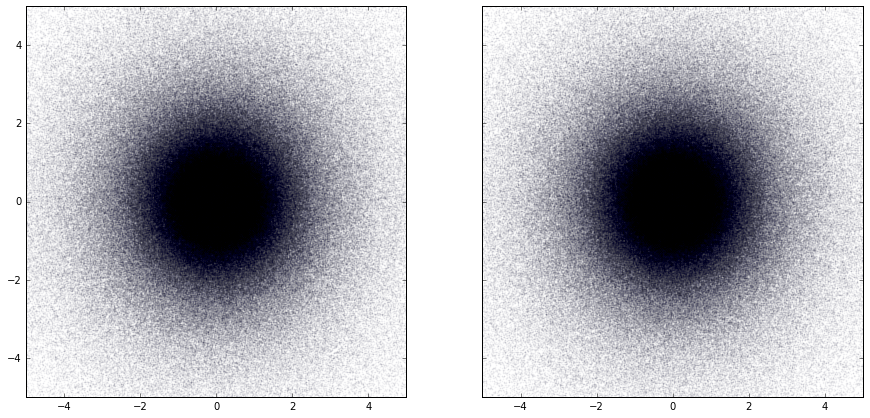

In [7]:
fig, ax = plt.subplots(1, 2 ,figsize=(15,7), sharey=True)
ax[0].scatter(s.data['pos'][:,0], s.data['pos'][:,1], s=0.3, alpha=0.05)
ax[1].scatter(pos_g[:,0], pos_g[:,1], s=0.3, alpha=0.05)
ax[0].set(xlim=(-5,5), ylim=(-5,5))
ax[1].set(xlim=(-5,5), ylim=(-5,5))

In [8]:
def plummer_dens(r, rc):
  m = Mplummer
  return 3*m/(4*np.pi*rc**3) * (1 + r**2/rc**2)**(-5/2)

In [9]:
# Define the radial bins
r_bins = np.logspace(np.log10(0.1), np.log10(20), 50)

# Calculate the number of particles in each radial bin
counts, _ = np.histogram(r_g, bins=r_bins)

# Calculate the volume of each radial bin
volumes = 4/3 * np.pi * (r_bins[1:]**3 - r_bins[:-1]**3)

# Calculate the density in each radial bin
density = counts*m_g[0] / volumes


Text(0, 0.5, '$\\rho (r) [ M_\\odot \\mathrm{kpc}^{-3}]$')

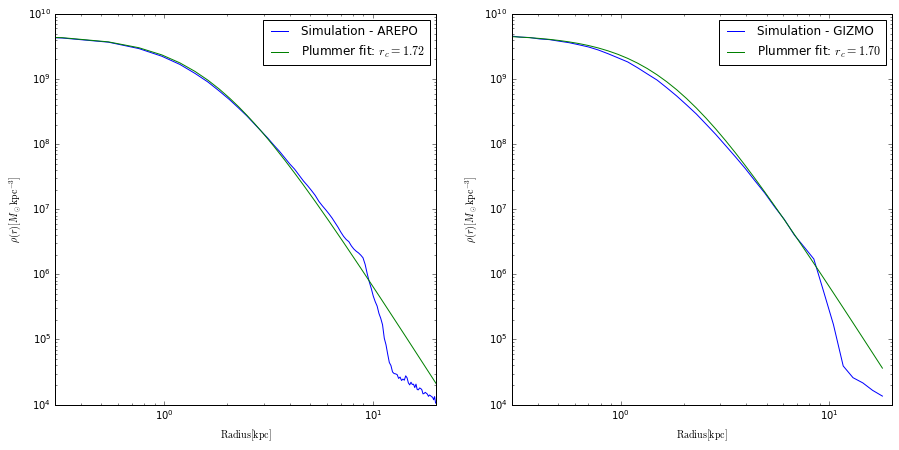

In [10]:
from scipy.optimize import curve_fit
dens_prof = s.get_raddens(center=[0,0,0])

popt, pcov = curve_fit(plummer_dens, dens_prof[1,:], dens_prof[0,:])
rc_fit_a = popt[0]
popt, pcov = curve_fit(plummer_dens, r_bins[:-1], density)
rc_fit_g = popt[0]

fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].loglog(dens_prof[1,:], dens_prof[0,:], label='Simulation - AREPO')
ax[0].loglog(dens_prof[1,:], plummer_dens(dens_prof[1,:], rc_fit_a), label=r'Plummer fit: $r_c={:.2f}$'.format(rc_fit_a))
ax[0].set_xlim(3e-1, 2e1)
ax[0].set_ylim(1e4, 1e10)
ax[0].legend()
ax[0].set_xlabel(r'$\mathrm{Radius} [\mathrm{kpc}]$')
ax[0].set_ylabel(r'$\rho (r) [ M_\odot \mathrm{kpc}^{-3}]$')

ax[1].loglog(r_bins[:-1], density, label='Simulation - GIZMO')
ax[1].loglog(r_bins[:-1], plummer_dens(r_bins[:-1], rc_fit_g), label=r'Plummer fit: $r_c={:.2f}$'.format(rc_fit_g))
ax[1].set_xlim(3e-1, 2e1)
ax[1].set_ylim(1e4, 1e10)
ax[1].legend()
ax[1].set_xlabel(r'$\mathrm{Radius} [\mathrm{kpc}]$')
ax[1].set_ylabel(r'$\rho (r) [ M_\odot \mathrm{kpc}^{-3}]$')
# plt.savefig('Plummer_fit.pdf')

In [11]:
rc_fit = (rc_fit_a + rc_fit_g) / 2.

In [12]:
T_eig_a = np.zeros((len(s.data['r']), 3))
T_eig_g = np.zeros((len(m_g), 3))

In [13]:
T_eig_a = np.sort(np.linalg.eigvals(s.data['ttij'].reshape(len(s.data['r']), 3, 3)), axis=1)
T_eig_g = np.sort(np.linalg.eigvals(TT_g.reshape(len(m_g), 3, 3)), axis=1)

In [14]:
T_eig_a *= (gyr /(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s))**2
# T_eig_g *= (gyr /(s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s))**2

In [15]:
T_str1_a = T_eig_a[:,2] + 1/3 * np.abs(T_eig_a[:,0] + T_eig_a[:,1] + T_eig_a[:,2])
T_str1_g = T_eig_g[:,2] + 1/3 * np.abs(T_eig_g[:,0] + T_eig_g[:,1] + T_eig_g[:,2])
T_str2_a = T_eig_a[:,2] - 1/2*(T_eig_a[:,1] + T_eig_a[:,0])
T_str2_g = T_eig_g[:,2] - 1/2*(T_eig_g[:,1] + T_eig_g[:,0])
# s.data['T_str'] = np.maximum( np.absolute(s.data['l1']), np.maximum(np.absolute(s.data['l2']), np.absolute(s.data['l3'])))

In [16]:
r = np.logspace(np.log10(0.1), np.log10(20), 50)
kde_a = gaussian_kde([s.data['r'], T_eig_a[:,2]])
kde_g = gaussian_kde([r_g, T_eig_g[:,2]])

r_a_grid, l1_a_grid = np.meshgrid(r, np.linspace(T_eig_a[:,2].min(), T_eig_a[:,2].max(), 50))
r_g_grid, l1_g_grid = np.meshgrid(r, np.linspace(T_eig_g[:,2].min(), T_eig_g[:,2].max(), 50))
z_a = kde_a(np.vstack([r_a_grid.ravel(), l1_a_grid.ravel()]))
z_g = kde_g(np.vstack([r_g_grid.ravel(), l1_g_grid.ravel()]))

In [17]:
idx_a = np.digitize(s.data['r'], r)
idx_g = np.digitize(r_g, r)
medianvalue_a = [np.median(T_eig_a[:,2][idx_a==k]) for k in range(50)]
medianvalue_g = [np.median(T_eig_g[:,2][idx_g==k]) for k in range(50)]
delta = (r[1] - r[0])
std_value_a = [T_eig_a[idx_a==k].std() for k in range(50)]
std_value_g = [T_eig_g[idx_g==k].std() for k in range(50)]

In [18]:
Trr = -1*G*Mplummer*(rc_fit**2 - 2*r**2)/((r**2 + rc_fit**2)**(5/2))
Trr *= solar_mass_g * gyr**2 / kpc**3

Tphiphi = -1*G*Mplummer/((r**2 + rc_fit**2)**(3/2))
Tphiphi *= solar_mass_g * gyr**2 / kpc**3

# Tstr = G*Mplummer*(r/rc_fit)**2 / (rc_fit**3 * (1 + (r/rc_fit)**2)**(5/2))
# Tstr *= gyr**2 / kpc**3
Tstr = Trr - Tphiphi

(0.1, 11.0)

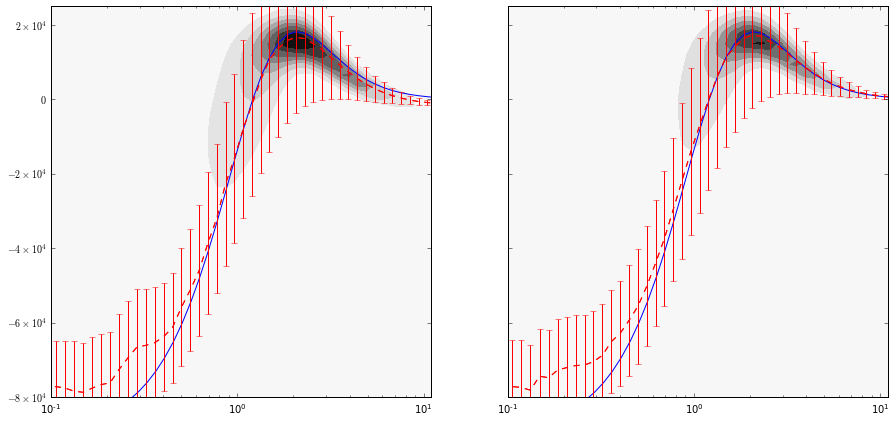

In [19]:
fig, ax = plt.subplots(1, 2 ,figsize=(15,7), sharey=True)
ax[0].contourf(r_a_grid, l1_a_grid, z_a.reshape(r_a_grid.shape), cmap='Greys')
ax[0].plot(r, Trr)
ax[0].plot(r - delta/2, medianvalue_a, 'r--')
ax[0].errorbar(r - delta/2, medianvalue_a, std_value_a, fmt='r--')
ax[0].set_xscale('log')
ax[0].set_yticks([-8e4, -6e4, -4e4, -2e4, 0, 2e4], labels=[r"$-8\times10^4$", r"$-6\times10^4$", r"$-4\times10^4$", r"$-2\times10^4$", r'$0$', r"$2\times10^4$"] )
ax[0].set_xlim(1e-1, 1.1e1)
ax[0].set_ylim(-8e4, 25000)

ax[1].contourf(r_g_grid, l1_g_grid, z_g.reshape(r_g_grid.shape), cmap='Greys')
ax[1].plot(r, Trr)
ax[1].plot(r - delta/2, medianvalue_g, 'r--')
ax[1].errorbar(r - delta/2, medianvalue_g, std_value_g, fmt='r--')
ax[1].set_xscale('log')
ax[1].set_xlim(1e-1, 1.1e1)

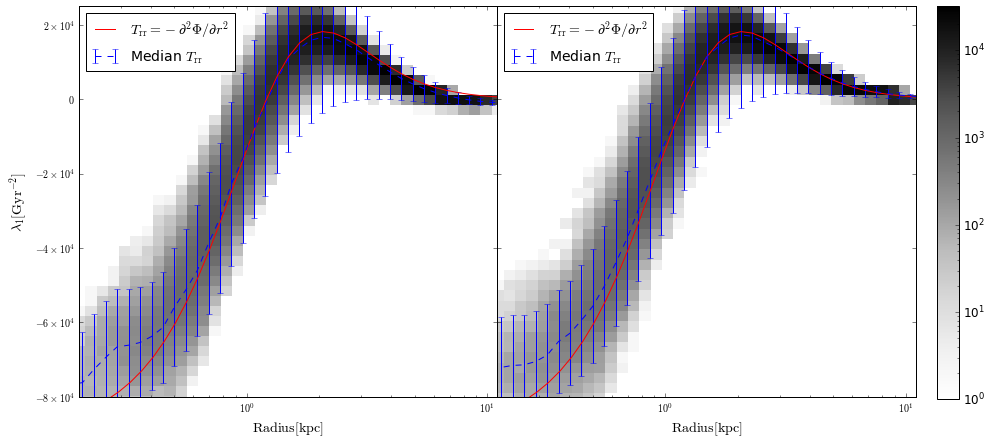

In [20]:
fig, ax = plt.subplots(1, 2 ,figsize=(15,7), sharey=True)
h = ax[0].hist2d(s.data['r'], T_eig_a[:,2], bins=(r, np.linspace((T_eig_a[:,2]).min(), (T_eig_a[:,2]).max(), 50)), cmap='Greys', norm=matplotlib.colors.LogNorm())
ax[0].errorbar(r - delta/2, medianvalue_a, std_value_a, fmt='b--', label=r'Median $T_\mathrm{rr}$')
ax[0].plot(r, Trr, c='r', label=r'$T_\mathrm{rr} =  -\partial^2 \Phi / \partial r^2$')
ax[0].set_xscale('log')
ax[0].set_xticks([1e0, 1e1], labels=[r"$10^0$", r"$10^1$"] )
ax[0].set_yticks([-8e4, -6e4, -4e4, -2e4, 0, 2e4], labels=[r"$-8\times10^4$", r"$-6\times10^4$", r"$-4\times10^4$", r"$-2\times10^4$", r'$0$', r"$2\times10^4$"] )
ax[0].set_xlim(2e-1, 1.1e1)
ax[0].set_ylim(-8e4, 25000)
ax[0].set_xlabel(r'$\mathrm{Radius} [\mathrm{kpc}]$', fontsize=14)
ax[0].set_ylabel(r'$\lambda_1 [\mathrm{Gyr}^{-2}]$', fontsize=14)
ax[0].legend(loc=0, fontsize=14)
h = ax[1].hist2d(r_g, T_eig_g[:,2], bins=(r, np.linspace((T_eig_g[:,2]).min(), (T_eig_g[:,2]).max(), 50)), cmap='Greys', norm=matplotlib.colors.LogNorm())
ax[1].errorbar(r - delta/2, medianvalue_g, std_value_g, fmt='b--', label=r'Median $T_\mathrm{rr}$')
ax[1].plot(r, Trr, c='r', label=r'$T_\mathrm{rr} =  -\partial^2 \Phi / \partial r^2$')
ax[1].set_xscale('log')
ax[1].set_xticks([1e0, 1e1], labels=[r"$10^0$", r"$10^1$"] )
ax[1].set_yticks([-8e4, -6e4, -4e4, -2e4, 0, 2e4], labels=[r"$-8\times10^4$", r"$-6\times10^4$", r"$-4\times10^4$", r"$-2\times10^4$", r'$0$', r"$2\times10^4$"] )
ax[1].set_xlim(2e-1, 1.1e1)
ax[1].set_ylim(-8e4, 25000)
ax[1].set_xlabel(r'$\mathrm{Radius} [\mathrm{kpc}]$', fontsize=14)
ax[1].legend(loc=0, fontsize=14)
fig.subplots_adjust(wspace=0.)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.78])
fig.colorbar(h[3], cax=cbar_ax)

plt.tick_params(labelsize=12)
# plt.tight_layout()
# fig.savefig('plummer_test.png')

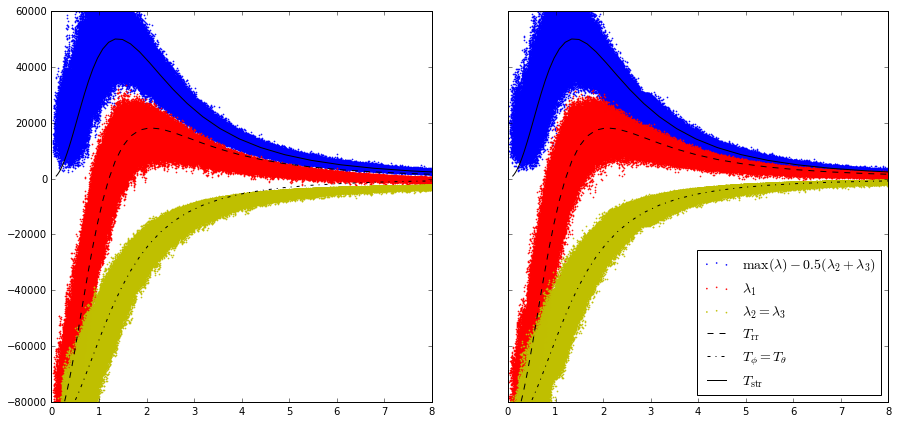

In [ ]:
fig, ax = plt.subplots(1, 2 ,figsize=(15,7), sharey=True)

ax[0].scatter(s.data['r'], T_str2_a, s=0.5, alpha=0.9, c='b', edgecolors='b')
ax[0].scatter(s.data['r'], T_eig_a[:,2], s=0.5, alpha=0.9, c='r', edgecolors='r')
ax[0].scatter(s.data['r'], .5*(T_eig_a[:,0] + T_eig_a[:,1]), s=0.5, alpha=0.9, c='y', edgecolors='y')
ax[0].plot(r, Trr, 'k--')
ax[0].plot(r, Tphiphi, 'k-.')
ax[0].plot(r, Tstr, 'k')
ax[0].set_xlim(0,8)
ax[0].set_ylim(-80000, 60000)

ax[1].scatter(r_g, T_str2_g, s=0.5, alpha=0.9, c='b', edgecolors='b', label=r'$\mathrm{max}(\lambda) - 0.5(\lambda_2 + \lambda_3)$')
ax[1].scatter(r_g, T_eig_g[:,2], s=0.5, alpha=0.9, c='r', edgecolors='r', label=r'$\lambda_1$')
ax[1].scatter(r_g, .5*(T_eig_g[:,0] + T_eig_g[:,1]), s=0.5, alpha=0.9, c='y', edgecolors='y', label=r'$\lambda_2 = \lambda_3$')
ax[1].plot(r, Trr, 'k--', label=r'$T_\mathrm{rr}$')
ax[1].plot(r, Tphiphi, 'k-.', label=r'$T_\mathrm{\phi} = T_\mathrm{\theta}$')
ax[1].plot(r, Tstr, 'k', label=r'$T_\mathrm{str}$')
ax[1].set_xlim(0,8)
ax[1].legend(loc=0, fontsize=14)